# 0. Table of content

1. Introduction and problem statement
2. Explore the data (before preprocessing)
3. Data Cleaning and additional analytics (after preprocessing):
4. Naïve Bayes Classifier
5. Extreme Gradient Boosting (XGBoost) Classifier

# 1. Introduction and problem statement

- Problem: SMS that we get are not always from family & friends --> Spam
- Solution: develop a system that filters out spam SMS


- How can we achieve a filter with a high accuracy?
    - data set with 5600 actual SMS (800 Spam and 4800 actual SMS)
    - analyse and visualize data to understand patterns
    - build prediction model that is trained on data
    - evaluate on train and test data


- Challenges:
    - High accuracy
    - No False Positives -> better to have some spam SMS than to filter out actual SMS
    - Unclean data set: SMS contain a lot of mistakes
    

In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
import numpy as np

import nltk
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

from collections import Counter


# 2. Explore the data (before preprocessing)

### 2.1. Load in the data:

In [2]:
#load in the text file:
with open("SMSSpamCollection.txt") as f:
    content = f.readlines()
#initialize emty list that later will be transformed to final data frame:
l = []
#loop trhough lines, get rid of new line signs and save in list:
for line in content:
    line = line.strip("\n")
    c = line.split("\t")
    l.append(c)
#transform list to df:
df = pd.DataFrame.from_records(l)
#rename columns:
df.columns = ["class","sms"]
#change ham to 0 and spam to 1
ind = df.loc[:,"class"]=="ham"
df.loc[ind,"class"] = 0
df.loc[-ind,"class"] = 1
#print the head of the df:
df.head(5)


,class,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 2.2) Data Analysis before cleaning

- Before cleaning the data, analyse following characteristics:
    - Uniqueness of SMS
    - Length of SMS
    - Presence of stopwors
    - Presence of special characters
    - Presence of hyperlink
    - Presence of phone numbers
    - Count of upper-case characters
    - Presence of smileys

(5574, 2)
False


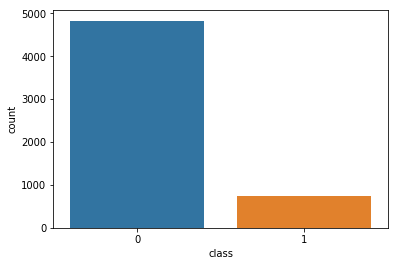

In [3]:
print(df.shape)
#check for Nas:
print(df.isnull().values.any())
#generate a count plot:
sns.countplot(x="class",data=df)


The df has 5574 rows and 2 columns (i.e. is it a spam or not and the content of the sms). The data set contains no NA's, so the reading of the file was successful. We can see that the data set is unbalanced with +/- 4800 sms being not spam, and around 800 sms being spam.

Lets check for doubles in the data:

In [4]:
print('Number of SMS:', df.sms.count())
print('Number of unique SMS: ', df.sms.nunique())


Number of SMS: 5574
Number of unique SMS:  5171


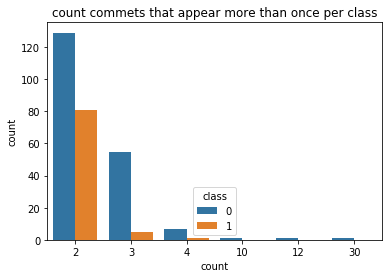

In [5]:
#Are the non-unique sms rather spam?

#set index to group on indexes:
df.set_index(['class','sms'],inplace=True)
#group by and get a count column:
df2 = pd.DataFrame(df.groupby(["sms","class"]).size())
df2.reset_index(inplace=True)
#get index of count larger than 1:
i = df2.iloc[:,2] > 1
df2.columns=["sms","class","count"]
df2 = df2[i]
#generate count plot:
sns.countplot(x="count",hue="class",data=df2)
plt.title('count commets that appear more than once per class')
plt.show()


#reset the index for the main data frame:
df.reset_index(inplace=True)

### 2.2.1. SMS Length

Lets check the distribution of the length of SMS, once in general, then for spams and not spams and see if we can get a conclusion out of this:

C:\Users\rick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


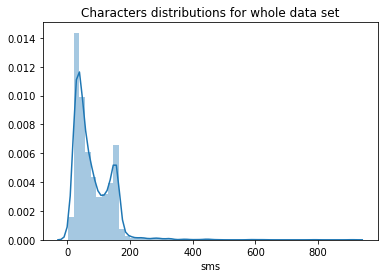

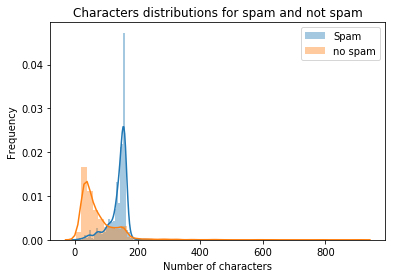

In [6]:
#distribution of comment lengths:

#whole data set:
sns.distplot(df['sms'].apply(len))
plt.title('Characters distributions for whole data set')
plt.show()

#spam:
ind = df.loc[:,"class"]==1
df_spam=df[ind]
sns.distplot(df_spam['sms'].apply(len),label="Spam")
#not spam:
df_not_spam=df[-ind]
ax = sns.distplot(df_not_spam['sms'].apply(len),label="no spam")
plt.legend()
plt.title('Characters distributions for spam and not spam')
ax.set(xlabel='Number of characters', ylabel='Frequency')
plt.show()



We can observe that the spam sms are longer on average, so it might be interesting to include the length of the sms as a feature.

In [7]:
df3 = df.copy()
df3['length'] = df3['sms'].apply(len)
df3.head(10)

,class,sms,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
5,1,FreeMsg Hey there darling it's been 3 week's n...,148
6,0,Even my brother is not like to speak with me. ...,77
7,0,As per your request 'Melle Melle (Oru Minnamin...,160
8,1,WINNER!! As a valued network customer you have...,158
9,1,Had your mobile 11 months or more? U R entitle...,154


### 2.2.2. Stopword presence

Another idea is the presence of stopwords, there could be a repetition of 'you' in spam messages as it would be an oriented commercial sms for example... 

It's also to check if we can clean the sms later on with stopwords. 

In [8]:
#SMS special characters count 
# creating a list with all reviews
sms = df.sms.tolist()

# creating special characters list
stopW = stopwords.words('english')

#empty list to save counts:
count_list = []
for s in sms:
    count = 0
    for c in s:
        if c in stopW :
            count = count + 1
    count_list.append(count)
    
#transform to series and add to df2 (which is a copy of df):
count_list = pd.Series(count_list)

df2 = df.copy()

df2['sw_count'] = count_list
df2.head()

,class,sms,sw_count
0,0,"Go until jurong point, crazy.. Available only ...",32
1,0,Ok lar... Joking wif u oni...,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,43
3,0,U dun say so early hor... U c already then say...,17
4,0,"Nah I don't think he goes to usf, he lives aro...",18


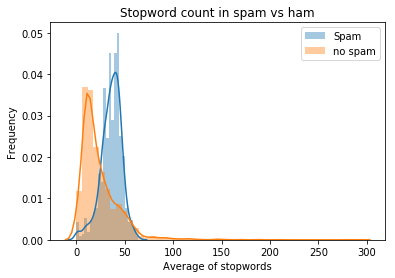

In [9]:
#spam:
ind = df2.loc[:,"class"]==1
df_spam=df2[ind]
sns.distplot(df_spam.loc[:,'sw_count'],label="Spam")

#not spam:
df_not_spam=df2[-ind]
ax = sns.distplot(df_not_spam.loc[:,'sw_count'],label="no spam")
plt.legend()
plt.title('Stopword count in spam vs ham')
ax.set(xlabel='Average of stopwords', ylabel='Frequency')
plt.show()

In [10]:
df3['sw_count'] = count_list
df3.head(10)

,class,sms,length,sw_count
0,0,"Go until jurong point, crazy.. Available only ...",111,32
1,0,Ok lar... Joking wif u oni...,29,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43
3,0,U dun say so early hor... U c already then say...,49,17
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18
5,1,FreeMsg Hey there darling it's been 3 week's n...,148,41
6,0,Even my brother is not like to speak with me. ...,77,29
7,0,As per your request 'Melle Melle (Oru Minnamin...,160,42
8,1,WINNER!! As a valued network customer you have...,158,40
9,1,Had your mobile 11 months or more? U R entitle...,154,50


### 2.2.3. Special Characters count

Same idea as numerics in text, we could expect a lot of exclamation points, question marks etc. 
This special characters list can be modified to find the pattern that distinguishes between spam and no spam, like using $ or a lot of ! and ?

In [11]:
#SMS special characters count 
# creating a list with all reviews
sms = df.sms.tolist()

# creating special characters list
special_characters = ["@","?","$",".","£"] # "?" distinguishes a lot!! "?" & "." works nicely as well!

#empty list to save counts:
count_list = []
for s in sms:
    count = 0
    for c in s:
        if c in special_characters :
            count = count + 1
    count_list.append(count)
    
#transform to series and add to df2 (which is a copy of df):
count_list = pd.Series(count_list)

df2 = df.copy()

df2['sc_count'] = count_list
df2.head(10)

,class,sms,sc_count
0,0,"Go until jurong point, crazy.. Available only ...",8
1,0,Ok lar... Joking wif u oni...,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,0,U dun say so early hor... U c already then say...,6
4,0,"Nah I don't think he goes to usf, he lives aro...",0
5,1,FreeMsg Hey there darling it's been 3 week's n...,3
6,0,Even my brother is not like to speak with me. ...,2
7,0,As per your request 'Melle Melle (Oru Minnamin...,1
8,1,WINNER!! As a valued network customer you have...,4
9,1,Had your mobile 11 months or more? U R entitle...,1


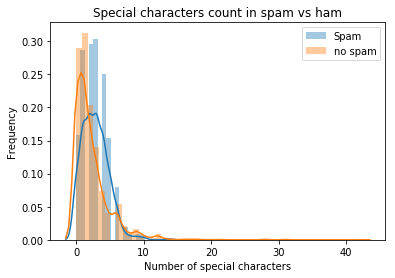

In [12]:
#spam:
ind = df2.loc[:,"class"]==1
df_spam=df2[ind]
sns.distplot(df_spam.loc[:,'sc_count'],label="Spam")

#not spam:
df_not_spam=df2[-ind]
ax = sns.distplot(df_not_spam.loc[:,'sc_count'],label="no spam")
plt.legend()
plt.title('Special characters count in spam vs ham')
ax.set(xlabel='Number of special characters', ylabel='Frequency')
plt.show()

Not the most clear-cut result... But could serve! Maybe we can improve by modifying the special characters list.

In [13]:
df3['sc_count'] = count_list
df3.head()

,class,sms,length,sw_count,sc_count
0,0,"Go until jurong point, crazy.. Available only ...",111,32,8
1,0,Ok lar... Joking wif u oni...,29,6,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43,1
3,0,U dun say so early hor... U c already then say...,49,17,6
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18,0


### 2.2.4. Hyperlink presence

In [14]:
sms = df.sms.tolist()

#empty list to save counts:
count_list = []
for s in sms:
    count = 0
    count += s.count('www') + s.count('http') 
    count_list.append(count)
    
count_list = pd.Series(count_list)
count_list = (count_list >= 1)

df2 = df.copy()
df2['hyperlink'] = count_list
#hyperlinks = (df2.loc[:,'hyp'] >=1)
#df2['hyperlinks'] = hyperlinks

df2.head(20)

,class,sms,hyperlink
0,0,"Go until jurong point, crazy.. Available only ...",False
1,0,Ok lar... Joking wif u oni...,False
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,False
3,0,U dun say so early hor... U c already then say...,False
4,0,"Nah I don't think he goes to usf, he lives aro...",False
5,1,FreeMsg Hey there darling it's been 3 week's n...,False
6,0,Even my brother is not like to speak with me. ...,False
7,0,As per your request 'Melle Melle (Oru Minnamin...,False
8,1,WINNER!! As a valued network customer you have...,False
9,1,Had your mobile 11 months or more? U R entitle...,False


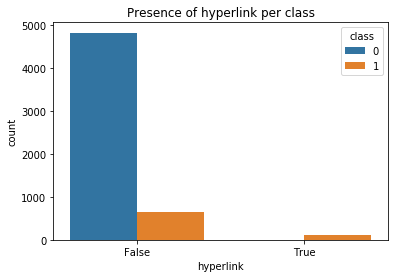

In [15]:
#count phone numbers per class:
sns.countplot(x="hyperlink",hue="class",data=df2)
plt.title('Presence of hyperlink per class')
plt.show()

In [16]:
df3['hyperlink'] = count_list
df3.head(10)

,class,sms,length,sw_count,sc_count,hyperlink
0,0,"Go until jurong point, crazy.. Available only ...",111,32,8,False
1,0,Ok lar... Joking wif u oni...,29,6,6,False
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43,1,False
3,0,U dun say so early hor... U c already then say...,49,17,6,False
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18,0,False
5,1,FreeMsg Hey there darling it's been 3 week's n...,148,41,3,False
6,0,Even my brother is not like to speak with me. ...,77,29,2,False
7,0,As per your request 'Melle Melle (Oru Minnamin...,160,42,1,False
8,1,WINNER!! As a valued network customer you have...,158,40,4,False
9,1,Had your mobile 11 months or more? U R entitle...,154,50,1,False


All messages that have an url are spam.

### 2.2.5. Digit count + Phone nb presence

We might be interested to see if there is a phone number in a sms. A simple idea is to count hte number of single digits in a sms, and if the number is larger then 8, the probability is high that it is a phone number (an adress for example should have less than 8 digits). As a result, we need to come up with a function counting the digits in each sms:

In [17]:
#SMS digit count 
# creating a list with all reviews
sms = df.sms.tolist()
#empty list to save counts:
count_list = []
for s in sms:
    count = 0
    for c in s:
        if c.isdigit():
            count = count + 1
    count_list.append(count)
    
#transform to series and add to df2 (which is a copy of df):
count_list = pd.Series(count_list)

df2 = df.copy()

df2['digit_count'] = count_list
phone = (df2.loc[:,'digit_count'] > 8)
df2['phone'] = phone
df2.head()

,class,sms,digit_count,phone
0,0,"Go until jurong point, crazy.. Available only ...",0,False
1,0,Ok lar... Joking wif u oni...,0,False
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,25,True
3,0,U dun say so early hor... U c already then say...,0,False
4,0,"Nah I don't think he goes to usf, he lives aro...",0,False


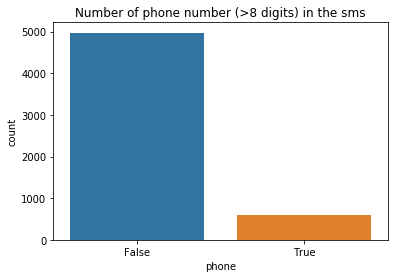

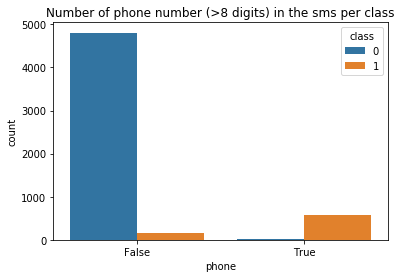

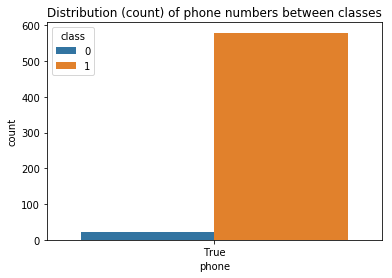

In [18]:
#make a count plot with phone numbers:
sns.countplot(x="phone",data=df2)
plt.title('Number of phone number (>8 digits) in the sms')
plt.show()

#count phone numbers per class:
sns.countplot(x="phone",hue="class",data=df2)
plt.title('Number of phone number (>8 digits) in the sms per class')
plt.show()

#look precisely at phone numbers for different classes:
ind = (df2.loc[:,"phone"] == True)
df4 = df2[ind]
sns.countplot(x="phone",hue="class",data=df4)
plt.title('Distribution (count) of phone numbers between classes')
plt.show()


In [19]:
df3['digit_count'] = count_list
phone = (df3.loc[:,'digit_count'] > 8)
df3['phone'] = phone
df3.head(10)

,class,sms,length,sw_count,sc_count,hyperlink,digit_count,phone
0,0,"Go until jurong point, crazy.. Available only ...",111,32,8,False,0,False
1,0,Ok lar... Joking wif u oni...,29,6,6,False,0,False
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43,1,False,25,True
3,0,U dun say so early hor... U c already then say...,49,17,6,False,0,False
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18,0,False,0,False
5,1,FreeMsg Hey there darling it's been 3 week's n...,148,41,3,False,4,False
6,0,Even my brother is not like to speak with me. ...,77,29,2,False,0,False
7,0,As per your request 'Melle Melle (Oru Minnamin...,160,42,1,False,1,False
8,1,WINNER!! As a valued network customer you have...,158,40,4,False,19,True
9,1,Had your mobile 11 months or more? U R entitle...,154,50,1,False,13,True


We get a very interesting insight from analysing phone numbers.

1) about 4900 sms's have not more than 8 digits (i.e. no phone numbers)  
2) around 600 sms's have a phone number in the text  
3) out of those 600, about 570 are marked as spam, only about 30 are not spam

As such, having more than 8 digits in the content might be a strong indicator for a spam sms.

### 2.2.6. Smiley presence

In [20]:
sms = df.sms.tolist()

#empty list to save counts:
smileys = [':-)',':)','(-:','(:',':-(',':(',')-:','):',':o',':O',':0',':‑)'
           ,':)',':-]',':]',':-3',':3',':->',':>','8-)','8)',':-}',':}',':o)',
           ':c)',':^)','=]','=)']


count_list = []
for s in sms:
    count = 0
    for i in range(len(smileys)):
        count += s.count(smileys[i])
    count_list.append(count)
    
count_list = pd.Series(count_list)
weeb = (count_list > 1)

df2 = df.copy()
df2['smileys'] = count_list
df2['weeb'] = weeb

df2.head(10)

,class,sms,smileys,weeb
0,0,"Go until jurong point, crazy.. Available only ...",0,False
1,0,Ok lar... Joking wif u oni...,0,False
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,0,False
3,0,U dun say so early hor... U c already then say...,0,False
4,0,"Nah I don't think he goes to usf, he lives aro...",0,False
5,1,FreeMsg Hey there darling it's been 3 week's n...,0,False
6,0,Even my brother is not like to speak with me. ...,0,False
7,0,As per your request 'Melle Melle (Oru Minnamin...,0,False
8,1,WINNER!! As a valued network customer you have...,0,False
9,1,Had your mobile 11 months or more? U R entitle...,0,False


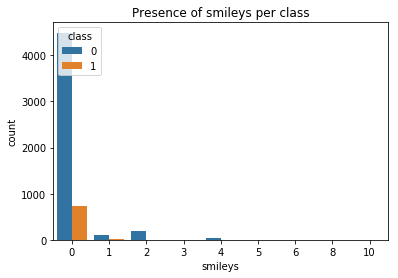

In [21]:
#count phone numbers per class:
sns.countplot(x="smileys",hue="class",data=df2)
plt.title('Presence of smileys per class')
plt.show()

Some spam can have on (very rarely 2) but only non spam have multiple emojis!

In [22]:
df3['smileys'] = count_list
df3['weeb'] = weeb
df3.head()

,class,sms,length,sw_count,sc_count,hyperlink,digit_count,phone,smileys,weeb
0,0,"Go until jurong point, crazy.. Available only ...",111,32,8,False,0,False,0,False
1,0,Ok lar... Joking wif u oni...,29,6,6,False,0,False,0,False
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43,1,False,25,True,0,False
3,0,U dun say so early hor... U c already then say...,49,17,6,False,0,False,0,False
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18,0,False,0,False,0,False


### 2.2.7. Upper-case presence

Next, we might be interested to count upper case letters. The underlying assumption is that spam sms's might use upper case to attract attention, while normal sms's might use a lot less upp-case letters.

In [23]:
#count upper-case:
count_list = []
for s in sms:
    count = 0
    for c in s:
        if c.isupper():
            count = count + 1
    count_list.append(count)
count_list

#transform to series and add to df2 (which is a copy of df):
count_list = pd.Series(count_list)

df2['upper_case'] = count_list

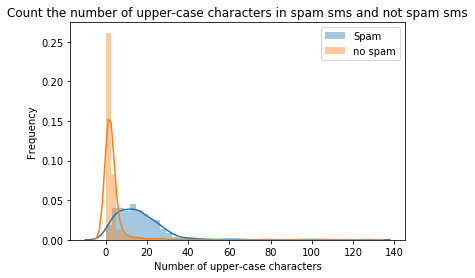

In [24]:
#spam:
ind = df2.loc[:,"class"]==1
df_spam=df2[ind]
sns.distplot(df_spam.loc[:,'upper_case'],label="Spam")

#not spam:
df_not_spam=df2[-ind]
ax = sns.distplot(df_not_spam.loc[:,'upper_case'],label="no spam")
plt.legend()
plt.title('Count the number of upper-case characters in spam sms and not spam sms')
ax.set(xlabel='Number of upper-case characters', ylabel='Frequency')
plt.show()

In [25]:
df3['upper_case'] = count_list
df3.head()

,class,sms,length,sw_count,sc_count,hyperlink,digit_count,phone,smileys,weeb,upper_case
0,0,"Go until jurong point, crazy.. Available only ...",111,32,8,False,0,False,0,False,3
1,0,Ok lar... Joking wif u oni...,29,6,6,False,0,False,0,False,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43,1,False,25,True,0,False,10
3,0,U dun say so early hor... U c already then say...,49,17,6,False,0,False,0,False,2
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18,0,False,0,False,0,False,2


While a lot of normal sms seem to have none upper-case characters, the spam emails tend to have more upper-case characters, which seems to confirm our. It might be a good idea to include the number of upper-case characters as a feature in our model.

### 2.3. Conclusion of data analysis before cleaning:

The main conclusions of the data analysis are as follows:
    
1)Data set contains around 5600 sms  
2)Unbalanced data set, i.e. 800 spam, 4800 not spam  
3)Spam sms tend to be longer than not spam sms  
4)Around 600 sms contain phone number, almost all are spam  
5)Spam sms tend to have more upper-case letters than non-spam sms  

# 3. Data Cleaning and additional analytics (after preprocessing):

### 3.1. Stopword removal:

We get rid of stopwords and certain punctuations (not dollar signs for example)

In [26]:
stopW = stopwords.words('english')
special_characters = ["@", "/", "#", ".", ",", "!", "?", "(", ")",
                      "-", "_","’","'", "\"", ":","=","+","&"
                      ,"`","*","0","1","2","3","4","5",
                      "6","7","8","9","'",'.','‘',';']
transformation_sc_dict = {initial:" " for initial in special_characters}

def preprocessing(sms):
  
    # Tokenization
    tokens = word_tokenize(sms)
    
    # Deleting words with  only one caracter
    tokens = [token for token in tokens if len(token)>2]
    
    # stopwords + lowercase
    tokens = [token.lower() for token in tokens if token.lower() not in stopW]   
    
    # Deleting specific characters
    tokens = [token.translate(str.maketrans(transformation_sc_dict)) for token in tokens]
        
    return tokens
  

# Creating a new column swith tokenized reviews
df3['tokens'] = df3['sms'].apply(preprocessing)
df3.head()

,class,sms,length,sw_count,sc_count,hyperlink,digit_count,phone,smileys,weeb,upper_case,tokens
0,0,"Go until jurong point, crazy.. Available only ...",111,32,8,False,0,False,0,False,3,"[jurong, point, crazy , available, bugis, gre..."
1,0,Ok lar... Joking wif u oni...,29,6,6,False,0,False,0,False,2,"[lar, , joking, wif, oni, ]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43,1,False,25,True,0,False,10,"[free, entry, wkly, comp, win, cup, final, tkt..."
3,0,U dun say so early hor... U c already then say...,49,17,6,False,0,False,0,False,2,"[dun, say, early, hor, , already, say, ]"
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18,0,False,0,False,0,False,2,"[nah, n t, think, goes, usf, lives, around, th..."


In [27]:
# creating a list with all reviews and more pre-processing
textos = df3.tokens.tolist()
texts = [[text.strip() for text in sms] for sms in textos]
clean_tokens = [[word for word in sms if word != ''] for sms in texts]
df3['clean_tokens'] = clean_tokens

    - Now we define a function to consistently plot the most frequent words:

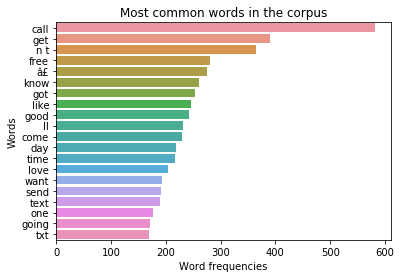

45175


In [28]:
def plot_frequent_words(list_of_words):    
    dist = nltk.FreqDist(list_of_words)
    X = [nb[1] for nb in dist.most_common(20)]
    y = [nb[0] for nb in dist.most_common(20)]
    ax = sns.barplot(X,y)
    ax.set(xlabel='Word frequencies',ylabel='Words',title='Most common words in the corpus')
    plt.show()

all_words = []
for sms in clean_tokens:
    for text in sms:
        all_words.append(text)
    
plot_frequent_words(all_words)
print(len(all_words))

### 3.2. Additional analytics after cleaning

We can go more in detail and see the specificities of most frequent words in ham and spam seperately.

* Identifying spam and ham

In [29]:
ind = df3.loc[:,"class"]==1
df_spam = df3[ind]
df_ham = df3[-ind]

* Applying the previous pre-processing as before

In [30]:
# Separating ham and spam and pre-processing them:
df_spam['tokens'] = df_spam['sms'].apply(preprocessing)
df_ham['tokens'] = df_ham['sms'].apply(preprocessing)

# creating a list with spam and ham respectively
textos_spam = df_spam.tokens.tolist()
textos_ham = df_ham.tokens.tolist()

# Additionnal pre-processing
texts_spam = [[text.strip() for text in sms] for sms in textos_spam]
texts_ham = [[text.strip() for text in sms] for sms in textos_ham]

clean_tokens_spam = [[word for word in sms if word != ''] for sms in texts_spam]
clean_tokens_ham = [[word for word in sms if word != ''] for sms in texts_ham]

C:\Users\rick\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\rick\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


* Plotting the results

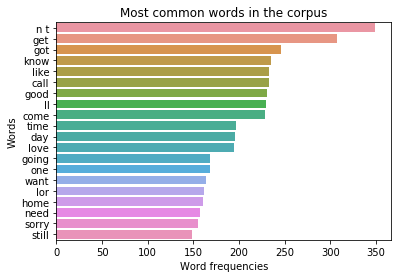

45175


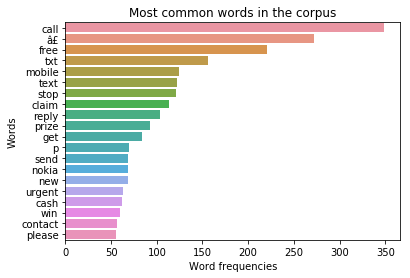

45175


In [31]:
all_words_ham = []
for sms in clean_tokens_ham:
    for text in sms:
        all_words_ham.append(text)
plot_frequent_words(all_words_ham)
print(len(all_words))

all_words_spam = []
for sms in clean_tokens_spam:
    for text in sms:
        all_words_spam.append(text)
plot_frequent_words(all_words_spam)
print(len(all_words))

We can already see that a few key-words will certainly help distinguish spam from ham : £, call, free, txt, mobile, prize etc... are buzzwords that you could expect from any commercial spam. Although we must be carefull as to not overfit our model and be able to detect only sms spams that resemble our data!

### 3.3. Lemmatiztion

We could consider using lemmatization to keep the root of the word only, although I don't think this might change much since we have a lot more grammar mistakes (done on purpose or not) given that sms are written more loosely. It might actually be an indicator for spam detection...

* Applying lemmatization

We just take the clean tokens that were preporcessed before for both ham and spam separately

In [32]:
df_ham['clean_tokens'] = clean_tokens_ham
df_spam['clean_tokens'] = clean_tokens_spam

lemmatizer = WordNetLemmatizer()
def lemmatize(tokens):
    tokens = [lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(token,pos='a'),pos='v'),pos='n') for token in tokens]
    return tokens  

df_ham['Lemmatisation'] = df_ham['clean_tokens'].apply(lemmatize)
df_spam['Lemmatisation'] = df_spam['clean_tokens'].apply(lemmatize)

C:\Users\rick\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\rick\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\rick\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

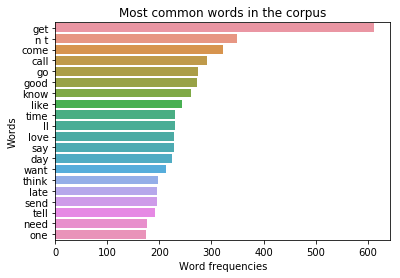

34844


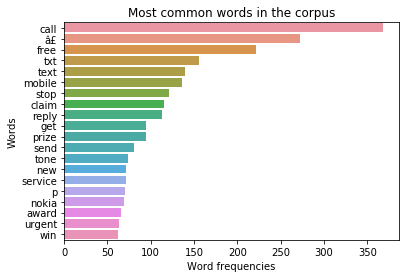

10331


In [33]:
all_words_ham = []
for sms in df_ham['Lemmatisation']:
    for text in sms:
        all_words_ham.append(text)
plot_frequent_words(all_words_ham)
print(len(all_words_ham))

all_words_spam = []
for sms in df_spam['Lemmatisation']:
    for text in sms:
        all_words_spam.append(text)
plot_frequent_words(all_words_spam)
print(len(all_words_spam))

We can't see any immediate effect but this might help for TF-IDF computations. Let's apply lemmatisation to our original data including both ham and spam:

In [34]:
df3['Lemmatisation'] = df3['clean_tokens'].apply(lemmatize)

### 3.4. Conclusion of EDA and preprocessing

### CONCLUSION

- Now that we have a good idea of what distinguishes spam sms from non-spam we can move on to predicting wether they appartein to one class or the other
- We'll be considering two models, the first one being a Naïve Bayes classifier which will use NLP info translated numerically to distinguish sms
- The second one will be an XGBoost classifier, which will use the features we've found throughout our EDA to classify spam and non-spam

# 4. Naïve Bayes Classifier

- Naïve bayes classification
    - Probalistic classification method relying on Bayes formula and strong independence (hence the term naïve!)
    - Use conditional law of X|y and law of y to retrieve an estimation of y|X
    - Given the law of y|X classify as +1 if P(y|X) >= 1/2, 0 otherwise

- Naïve bayes classification for spam detection
    - Naïve Bayes classifier very famous for spam detection (emails, sms...)
    - Uses NLP features such as wordcount, TF-IDF etc...
    - We compare Naïve bayes with XGBoost (implemented in next section) to benchmark our models and check scalability

### 4.1 Load in the data

- Loading the data
    - Naïve bayes classifier relies on NLP information retrieved from sms
    - Thus it will have its own version of pre-processed sms as these are its features in essence
    - We use a 80/20 train test split

In [36]:
data = df3.copy()
X = data['sms']
y = data['class']

#make train test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

### 4.2 Preprocessing the data

- Pre-processing data
    - As mentionned before, the processing is key for this classifier
    - We reverse engineer the preprocessing we apply (stopwords, punctuation etc)
    - Some characters are a major distinguisher between ham and spam ("£" for example!)

In [37]:
def clean_text(text):
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='"\'%&()*,-./:;<=>?[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

### 4.3 Vectorization

   - We need to transform strings into numerical data for the classifier to understand them
   - Various methods exist, Wordcount and TF-IDF will be our focus here
   - Drawbacks of wordcount will be explained in next slide

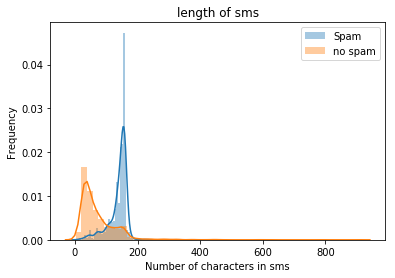

In [38]:
#spam:
ind = data.loc[:,"class"]==1
data_spam=data[ind]
sns.distplot(data_spam.loc[:,'length'],label="Spam")

#not spam:
data_ham=data[-ind]
ax = sns.distplot(data_ham.loc[:,'length'],label="no spam")
plt.legend()
plt.title('length of sms')
ax.set(xlabel='Number of characters in sms', ylabel='Frequency')
plt.show()

### 4.3.1 Wordcount vectorization

   - As its title states it, we basically count the number of times a word appears in an sms
   - Main drawback is that it is subject to the length of the sms (i.e higher count just because there are more words in an sms)
   - The classifier computes conditional laws for classification on these transformed numerical features

In [39]:
vectorizer = CountVectorizer(
    stop_words="english",
    preprocessor=clean_text)

data_train_count = vectorizer.fit_transform(X_train)
data_test_count = vectorizer.transform(X_test)

### 4.3.2. TF-IDF vectorization

   - Solves length of sms problem mentionned in wordcount vectorization by weighting word counts (loosely speeaking)
   - TF score(word,text) : # of word in text / total # of words in text | IDF score(word): log(# of texts/ # of texts where word appears)
   - TF-IDF(word,text):

In [40]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    preprocessor=clean_text)

data_train_tfidf = vectorizer.fit_transform(X_train)
data_test_tfidf = vectorizer.transform(X_test)

### 4.4 Building the model

### 4.4.1 Model using wordcount vectorization

In [41]:
clf_count = MultinomialNB()
clf_count.fit(data_train_count,y_train)

#predict on test data:
pred_count = clf_count.predict(data_test_count)
pred_count_prob = clf_count.predict_proba(data_test_count)[:,1]

### 4.4.2 Model using TF-IDF vectorization

In [42]:
clf_tfidf = MultinomialNB()
clf_tfidf.fit(data_train_tfidf,y_train)

#predict on test data:
pred_tfidf = clf_tfidf.predict(data_test_tfidf)
pred_count_tfidf = clf_tfidf.predict_proba(data_test_tfidf)[:,1]

### 4.5 Model evaluation

### 4.5.1 Results for wordcount vectoriation

In [43]:
print("\n")
print("Using count vectorization")
print("\n")
acc_count = accuracy_score(y_test,pred_count)
prec_count = precision_score(y_test, pred_count)
sens_count = recall_score(y_test,pred_count)

print("Accuracy :", acc_count)
print("Precision :", prec_count)
print("Sensitivity :", sens_count)



Using count vectorization


Accuracy : 0.989237668161435
Precision : 0.9647887323943662
Sensitivity : 0.9513888888888888


We correctly classified 137 sms as spam


We correctly classified 966 sms as not spam


We inccorrectly classified 5 sms as spam


We inccorrectly classified 7 sms as not spam




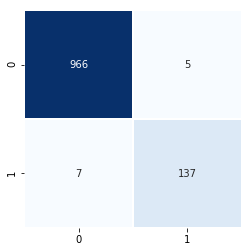

In [44]:
confusion = metrics.confusion_matrix(y_test, pred_count)
sns.heatmap(confusion, annot = True, cbar = False, square = True, cmap = 'Blues', fmt = 'g', linewidths = 0.5)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print("We correctly classified",TP,"sms as spam")
print("\n")
print("We correctly classified",TN,"sms as not spam")
print("\n")
print("We inccorrectly classified",FP,"sms as spam")
print("\n")
print("We inccorrectly classified",FN,"sms as not spam")
print("\n")

AUC score : 0.9973752717702254




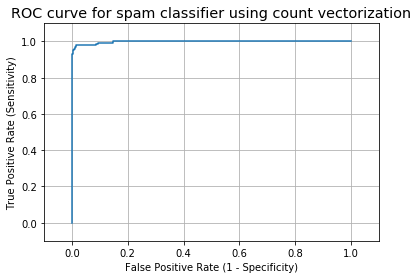

In [45]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_count_prob)

plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for spam classifier using count vectorization')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print("AUC score :",metrics.roc_auc_score(y_test, pred_count_prob))
print("\n")

### 4.5.2 Results for TF-IDF vectorization

In [46]:
print("\n")
print("Using TF-IDF vectorization")
print("\n")

acc_tfidf = accuracy_score(y_test,pred_tfidf)
prec_tfidf = precision_score(y_test, pred_tfidf)
sens_tfidf = recall_score(y_test,pred_tfidf)

print("Accuracy :", acc_tfidf)
print("Precision :", prec_tfidf)
print("Sensitivity :", sens_tfidf)



Using TF-IDF vectorization


Accuracy : 0.9721973094170404
Precision : 1.0
Sensitivity : 0.7847222222222222


We correctly classified 113 sms as spam


We correctly classified  971  sms as not spam


We inccorrectly classified  0  sms as spam


We inccorrectly classified  31  sms as not spam




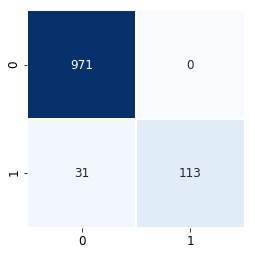

In [47]:
confusion = metrics.confusion_matrix(y_test, pred_tfidf)
sns.heatmap(confusion, annot = True, cbar = False, square = True, cmap = 'Blues', fmt = 'g', linewidths = 0.5)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print("We correctly classified",TP,"sms as spam")
print("\n")
print("We correctly classified ",TN," sms as not spam")
print("\n")
print("We inccorrectly classified ",FP," sms as spam")
print("\n")
print("We inccorrectly classified ",FN," sms as not spam")
print("\n")

AUC score : 0.9955658542167297




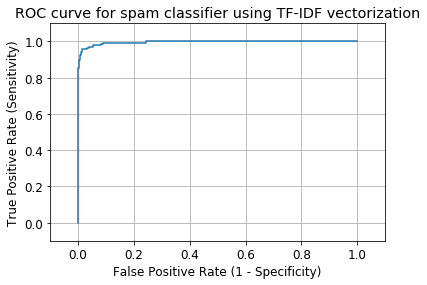

In [48]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_count_tfidf)

plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for spam classifier using TF-IDF vectorization')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print("AUC score :",metrics.roc_auc_score(y_test, pred_count_tfidf))
print("\n")

### 4.6. Conclusion

   - What matters the most for us is to not classify non-spam sms as spam (False positives must be 0)
   - We can see that TF-IDF vectorization does exactly that but at the cost of more spam not being correctly classified (more Fasle Negatives)
   - Wordcount vectorization has some False positives, we thus prefer TF-IDF vectorization over Wordcount

   - Disregarding these details both models are very precise and accurate
   - the auc score is very similar for both 
   - We'll see how XGBoost fares in comparison in the next section

# 5. Extreme Gradient Boosting (XGBoost) Classifier

- Extreme Gradient Boosting method
- Boosting: ensemble learning technique of building many models sequentially
    - new model attempting to correct for the deficiencies in the previous model
    - this is an ensemble method that seeks to create a strong classifier (model) based on “weak” classifiers
-	Gradient boosting:  updating model using gradient descent
-	XGBoost implements this algorithm for decision tree boosting

![Drag Racing -fullwidth](mystery-box.jpg)


### 5.1. Load and prepare data for XGBoost

In [49]:
#import file with features:
xgbdata = df3.copy()
xgbdata.head(3)

,class,sms,length,sw_count,sc_count,hyperlink,digit_count,phone,smileys,weeb,upper_case,tokens,clean_tokens,Lemmatisation
0,0,"Go until jurong point, crazy.. Available only ...",111,32,8,False,0,False,0,False,3,"[jurong, point, crazy , available, bugis, gre...","[jurong, point, crazy, available, bugis, great...","[jurong, point, crazy, available, bugis, great..."
1,0,Ok lar... Joking wif u oni...,29,6,6,False,0,False,0,False,2,"[lar, , joking, wif, oni, ]","[lar, joking, wif, oni]","[lar, joke, wif, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43,1,False,25,True,0,False,10,"[free, entry, wkly, comp, win, cup, final, tkt...","[free, entry, wkly, comp, win, cup, final, tkt...","[free, entry, wkly, comp, win, cup, final, tkt..."


In [50]:
#change False to 0 and True to 1:
#define function:
def bool_to_bin(colname):
    index_false = xgbdata.loc[:,colname]==False
    xgbdata.loc[index_false,colname]=0
    xgbdata.loc[-index_false,colname]=1

bool_to_bin("hyperlink")
bool_to_bin("phone")
bool_to_bin("weeb")

xgbdata = xgbdata.loc[:,["class","length","sc_count","hyperlink","digit_count","smileys","upper_case"]]

xgbdata.head(5)

,class,length,sc_count,hyperlink,digit_count,smileys,upper_case
0,0,111,8,0,0,0,3
1,0,29,6,0,0,0,2
2,1,155,1,0,25,0,10
3,0,49,6,0,0,0,2
4,0,61,0,0,0,0,2


In [51]:
#separate data in target and predictor variables:
X = xgbdata.iloc[:,1:]
y = xgbdata.iloc[:,0]

#transform into Dmatrix (faster and supported by xgboost):
dmatrix = xgb.DMatrix(data=X,label=y)

In [52]:
#make train test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=111)
#set seed in order to be able to reproduce results

### 5.2 Fine-tuning of the XGBoost model with Cross-Validation

In [53]:
%%capture
#CROSS VALIDATION 


#generate classifier:
params={"max_depth":5, 
        "min_child_weight":2, 
        "eta": 0.1, 
        "subsamples":0.9, 
        "objective" : "binary:logistic", 
        "eval_metric": ["error","logloss","auc"]}
rounds = 200
result = xgb.cv(params=params, nfold=5, dtrain=dmatrix, num_boost_round=rounds, as_pandas=True, seed=10,early_stopping_rounds=50)


In [54]:
result.iloc[105,:]

train-auc-mean        0.998079
train-auc-std         0.000272
train-error-mean      0.010002
train-error-std       0.000703
train-logloss-mean    0.032821
train-logloss-std     0.001845
test-auc-mean         0.990494
test-auc-std          0.004447
test-error-mean       0.015428
test-error-std        0.003419
test-logloss-mean     0.057447
test-logloss-std      0.009932
Name: 105, dtype: float64

- early stopping: 106 --> num_boosting_rounds = 106
- max_depth: maximum depth of a tree -> increasing this value will make the model more complex and more likely to overfit
    - max_depth = 5
- min_child_weight: corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.
    - min_child_weight = 2
- eta: Step size shrinkage used in update to prevents overfitting
    - eta = 0.1
- subsample: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees
    - subsample = 0.9

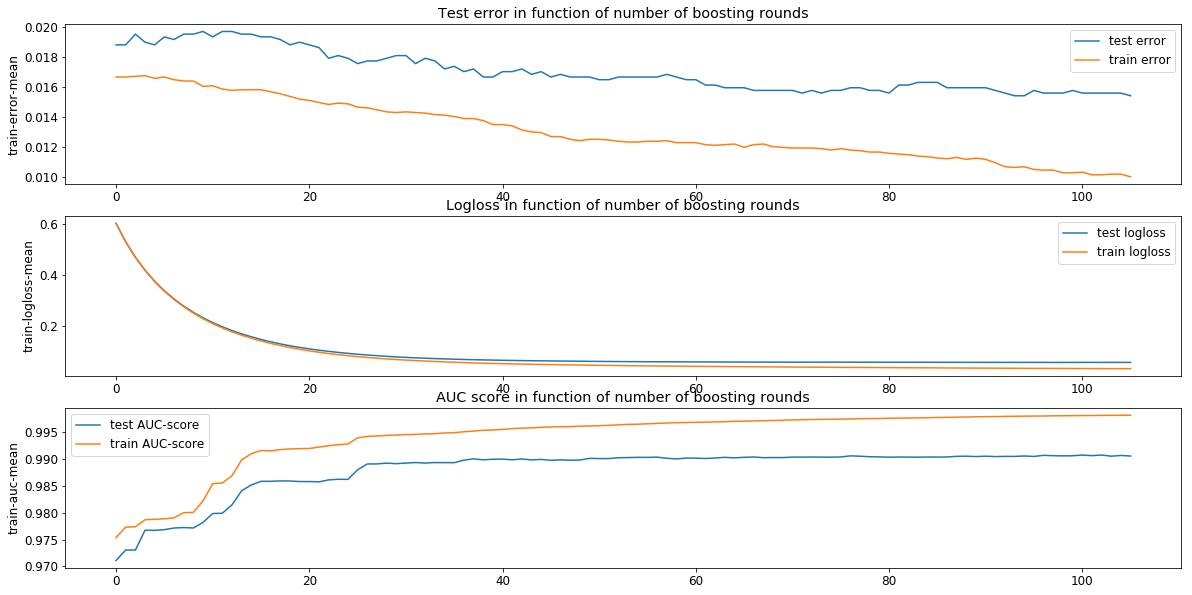

In [55]:
test_error = result.loc[:,"test-error-mean"]
train_error = result.loc[:,"train-error-mean"]
test_logloss = result.loc[:,"test-logloss-mean"]
train_logloss = result.loc[:,"train-logloss-mean"]
test_auc = result.loc[:,"test-auc-mean"]
train_auc = result.loc[:,"train-auc-mean"]
n = range(len(test_auc))

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

sns.lineplot(n,test_error,ax=ax1,label="test error")
sns.lineplot(n,train_error,ax=ax1, label="train error")
ax1.set_title("Test error in function of number of boosting rounds")
ax1.legend()

sns.lineplot(n,test_logloss,ax=ax2,label="test logloss")
sns.lineplot(n,train_logloss,ax=ax2,label="train logloss")
ax2.set_title("Logloss in function of number of boosting rounds")
ax2.legend()

sns.lineplot(n,test_auc,ax=ax3,label="test AUC-score")
sns.lineplot(n,train_auc,ax=ax3,label="train AUC-score")
ax3.set_title("AUC score in function of number of boosting rounds")
ax3.legend()

plt.show()

### 5.3Train the model and evaluate it on test set

In [56]:

xg_reg = xgb.XGBRegressor(max_depth=5,
                          eta = 0.1,
                          min_child_weight = 2,
                          subsamples = 0.9,
                          objective = "binary:logistic",
                          num_boost_round=106
                         )
#make prediction:
xg_reg.fit(X_train,y_train)

xg_reg.save_model("xg_reg")
import joblib
joblib.dump(xg_reg,"xg_reg2.bin")


['xg_reg2.bin']

We see that all the metrics converge with the number of boosting rounds. There seems to be no issue with overfitting either. As such, lets chooser 50 boosting rounds for the following tests.

In [57]:
#TEST ERROR:
y_pred = xg_reg.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy2 = accuracy_score(y_test, predictions)
print("Accuracy for test set: %.2f%%" % (accuracy2 * 100.0))


Accuracy for test set: 98.81%


C:\Users\rick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.9937158469945355


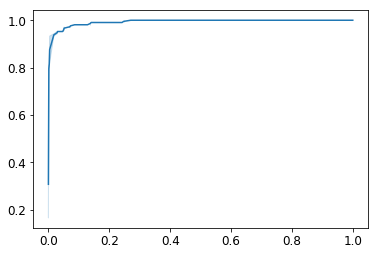

In [58]:
#plot area under the curve:
roc = roc_curve(y_test,y_pred)
x = roc[0]
y = roc[1]
sns.lineplot(x,y)
print(roc_auc_score(y_test,y_pred))


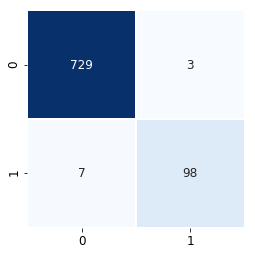

In [59]:
#generate a confusion matrix
cm = confusion_matrix(y_test,np.round(y_pred))
sns.heatmap(cm,annot=True,cbar=False,square=True,cmap='Blues',fmt='g',linewidths=0.5)


### 5.4 Model Interpretation: 

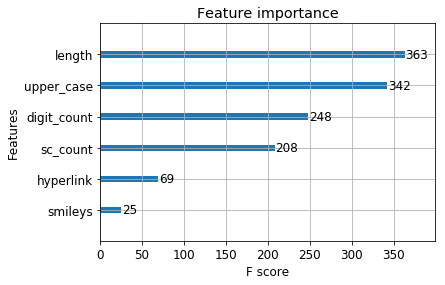

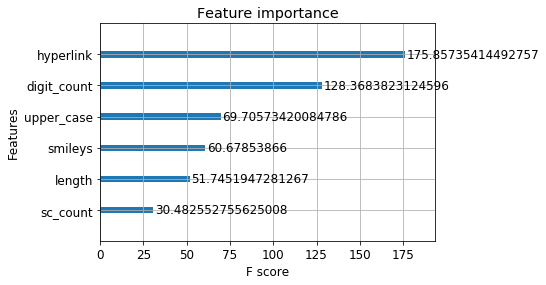

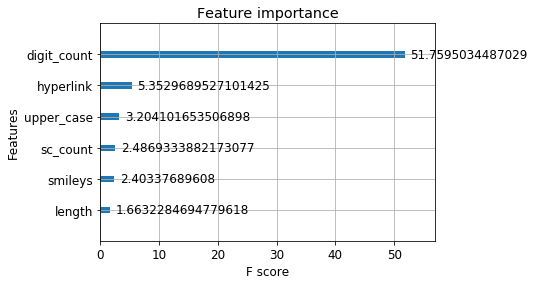

In [60]:
# plot feature importance
xgb.plot_importance(xg_reg,importance_type="weight")
xgb.plot_importance(xg_reg,importance_type="cover")
xgb.plot_importance(xg_reg,importance_type="gain")


- result completely different, why?
    - weight: The number of times a feature is used to split the data across all trees
    - cover: The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits
    - gain: The average training loss reduction gained when using a feature for splitting
- Which one to choose? Problem: Neither one of the 3 is consitent
    - consitecy:  Whenever we change a model such that it relies more on a feature, then the attributed importance for that feature should not decrease
    
Tree SHAP method is mathematically equivalent to averaging differences in predictions over all possible orderings of the features, rather than just the ordering specified by their position in the tree -> consistent

In [61]:
#import shap
#shap.TreeExplainer(xg_reg).shap_values(X_train) 
#call shap.summary_plot(shap_values, X_train)

# 6. Conclusion

- Summary of results:
    - Naive Bayes:
        - Wordcount vectorization
            - Accuracy = 0.9892
            - AUC score = 0.9966
            - Number of FP = 5
            - Number of FN = 7
        - TF-IDF vectorization
            - Accuracy = 0.9713
            - AUC score = 0.9948
            - Number of FP = 0
            - Number of FN = 31
    - XGBoost:
        - Specific features extracted from SMS
            - Accuracy = 0.9881
            - AUC score = 0.9937
            - Number of FP = 3
            - Number of FN = 7
- As we want no FP, we chose TF-IDF vectoization with Naive Bayes
- A lot of potential for the XGBoost model
- Future work:
    - Try XGBoost on TF-IDF vectorization
    - Develop new features
    - Fine-tune parameters (NOT looking at test-set)
    - Find more data (more divers), and test models on this data as well

In [62]:
print("compiled successfully!")

compiled successfully!
